# Predicting On-time Delivery of Online Purchases
## AAI-510 Team 7 Final Project

Team 7:  Ken Devoe, Tyler Foreman, Geoffrey Fadera

University of San Diego, Applied Artificial Intelligence

Date:  June 24, 2024

GitHub Repository: https://github.com/kdevoe/aai510-group7

## Business Problem Statement and Approach

**Business Understanding**

SevenSeas, Inc. is an online retailer, selling a broad catalog of products through various e-commerce channels.  As a company operating at a global scale, SevenSeas ships direct to customers all over the world by air, sea and land.  Recently, there has been an uptick in customer complaints due to shipments not being delivered on time.  This has resulted in unhappy customers that have posted negative reviews online as well as an increase in returns and requests for refunds.

Company leadership has flagged this as an urgent issue to resolve.  Our data science team has been tasked to develop a method to better predict on-time delivery of products based on a combination of characteristics that describe the shipping medium and customer profile.  These predictions will need to be made prior to the package being prepared for shipment.  To facilitate this, the team has compiled a dataset of key characteristics that are known at the time of purchase.  These predictions will enable SevenSeas to adjust the shipping methods for those packages that are determined to be at risk of delayed shipment using standard methods and ensure that on-time delivery is improved.

The key objectives of this project are:

- Develop a machine learning model that can predict whether a package will be delivered on-time based on a set of characteristics known at the time of purchase.
- Determine which features of the shipping medium are contributing most to predicting delayed deliveries
 

**Approach**

Based on the team's business understanding of the business challenge and dataset, it was determined that the best way to frame this problem was as a supervised learning task to perform binary classification.  That is, the model would be trained on the labeled dataset to make binary predictions as to whether the shipment would be on-time (1) or late (0).  As such, the team seeks to experiment with several candidate classical machine learning model architectures that are suited for the binary classification task, evaluate their performance and select the model whose performance characteristics are best suited to solve the business challenge.

The team employed the following appraoch and evaluation criteria to develop the optimal solution to the problem:

- Conduct exploratory data analysis to determine the shape of the data, the cleanliness and perform initial evaluation on correlation of the features
- Prepare the dataset for modeling: clean missing data, encode categorical features, normalize numerical values
- Run training, hyperparameter tuning and performance evaluation of 6 classial supervised machine learning model architectures (all as classifiers):
    - Logistic Regression (baseline model)
    - Naive Bayes
    - Decision Tree
    - Random Forest
    - XGBoost 
    - Support Vector Machine
    - K-Nearest Neighbor

**Evaluation Criteria**

The primary business objective is to optimize the ability to accurately predict late delivery of packages.  It is critical to the business that the model does not incorrectly classify these shipments.  The evaluation criteria will therefore focus on optimizing for minimizing false positives (false on-time deliveries).  It is acceptable for the business to handle some rate of false alarms (false late deliveries) but these should be minimized as much as possible.

# Part I: Exploratory Data Analysis (EDA)

EDA was performed to both check for how the data should be handled as well as identifying simple patterns and correlations between data features.

## Imports and Setup

In [573]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree

from dataprep.eda import plot
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from xgboost.sklearn import XGBClassifier

### Setup - Constants and Settings

In [574]:

DISPLAY_DATAPREP = False  # Dataprep can mess up display outputs, setting as off by default
TARGET_NAMES = ['late', 'on-time'] # instead of '0' and '1's, create display labels for target classes 
plt.set_loglevel('WARNING')  # Reducing error messages

### Setup - Common Functions

In [575]:
# aai-510-group7 confusion matrix
def aai510_grp7_confusion_matrix(y_true = [], y_pred = [], title = 'Model X'):

    # generate confusion matrix for model1
    cnf_matrix = confusion_matrix(y_true, y_pred)

    # create group names for true negatives, false positives, false negatives, and true positives 
    group_names = ['TRUE late','FALSE on-time','FALSE late','TRUE on-time']

    # list counts and percentages for each group above.
    group_counts = cnf_matrix.flatten()
    group_percentages = [format(value, ".2%") for value in group_counts/np.sum(group_counts)]

    # create a label for each group by combining the group name, counts, and percentages
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    # display confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues', 
                xticklabels = TARGET_NAMES, 
                yticklabels = TARGET_NAMES)
    plt.xlabel('PREDICTED')
    plt.ylabel('ACTUAL')
    title = title + ': CONFUSION MATRIX'
    plt.title(title, fontsize=14)

In [576]:
# aai-510-group7 classification report
def aai510_grp7_class_report(y_true = [], y_pred = [], title = 'Model X'):
    print('\033[1m'+title+': CLASSIFICATION REPORT')
    print('\033[0m')
    print(classification_report(y_true, y_pred, target_names=TARGET_NAMES))

## Data Download and Overview

In [577]:
datafile = './data/shipping.csv'
TARGET = 'Reached.on.Time_Y.N'

df = pd.read_csv(datafile)

# Drop the ID column
df = df.drop(columns='ID')


display(df)

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,D,Flight,4,2,177,3,low,F,44,1233,1
1,F,Flight,4,5,216,2,low,M,59,3088,1
2,A,Flight,2,2,183,4,low,M,48,3374,1
3,B,Flight,3,3,176,4,medium,M,10,1177,1
4,C,Flight,2,2,184,3,medium,F,46,2484,1
...,...,...,...,...,...,...,...,...,...,...,...
10994,A,Ship,4,1,252,5,medium,F,1,1538,1
10995,B,Ship,4,1,232,5,medium,F,6,1247,0
10996,C,Ship,5,4,242,5,low,F,4,1155,0
10997,F,Ship,5,2,223,6,medium,M,2,1210,0


In [578]:
df.describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


The dataset consisted of a total of approximately 11,000 examples, with 10 input variables and one target variable.

An overview of the products being shipped:

- $96 - $310 dollar value range
- 1 kg - 7.8 kg in weight (roughly 2 - 20 lbs)
- Discount between 1 and 65 (4 - 10 IQR) as a percentage.

In [579]:
if DISPLAY_DATAPREP:
    plot(df)

## Missing Values

No values are missing from the dataset.

In [580]:
# Display the number of missing values per variable
display(df.isnull().sum())

Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

## Target Variable Distribution

The target variable of whether the shipment was on time or not does not show a significant class imbalance. Approximately 60% of the data is for shipments that reached on time, with the remaining 40% not arriving on time.

In [581]:
if DISPLAY_DATAPREP:
    plot(df, TARGET)

## Data Types

Of the 11 variables 7 are numerical and 4 are categorical. Categorical data will need to be encoded in some way before full analysis can be completed. Of the categorical data only product importance is ordinal (low, medium, high) and the remaining categorical variables do not have relative importance between their values.

In [582]:
# Plot the data types
data_types = df.dtypes
display(data_types)


Warehouse_block        object
Mode_of_Shipment       object
Customer_care_calls     int64
Customer_rating         int64
Cost_of_the_Product     int64
Prior_purchases         int64
Product_importance     object
Gender                 object
Discount_offered        int64
Weight_in_gms           int64
Reached.on.Time_Y.N     int64
dtype: object

## General Correlation between Variables

To compare general trends between variables a few different methods are used, including pairplot and a correlation matrix. Trends are then further investigated in the individual variable correlation section further below.

### Pairplot

A couple trends stand out from the pairplot:

- Both discount offered and weight in grams appear to have some correlation to the target variable of on-time shipments

- Weight in grams shows some interesting stratification patterns against cost of product and discount offered. 

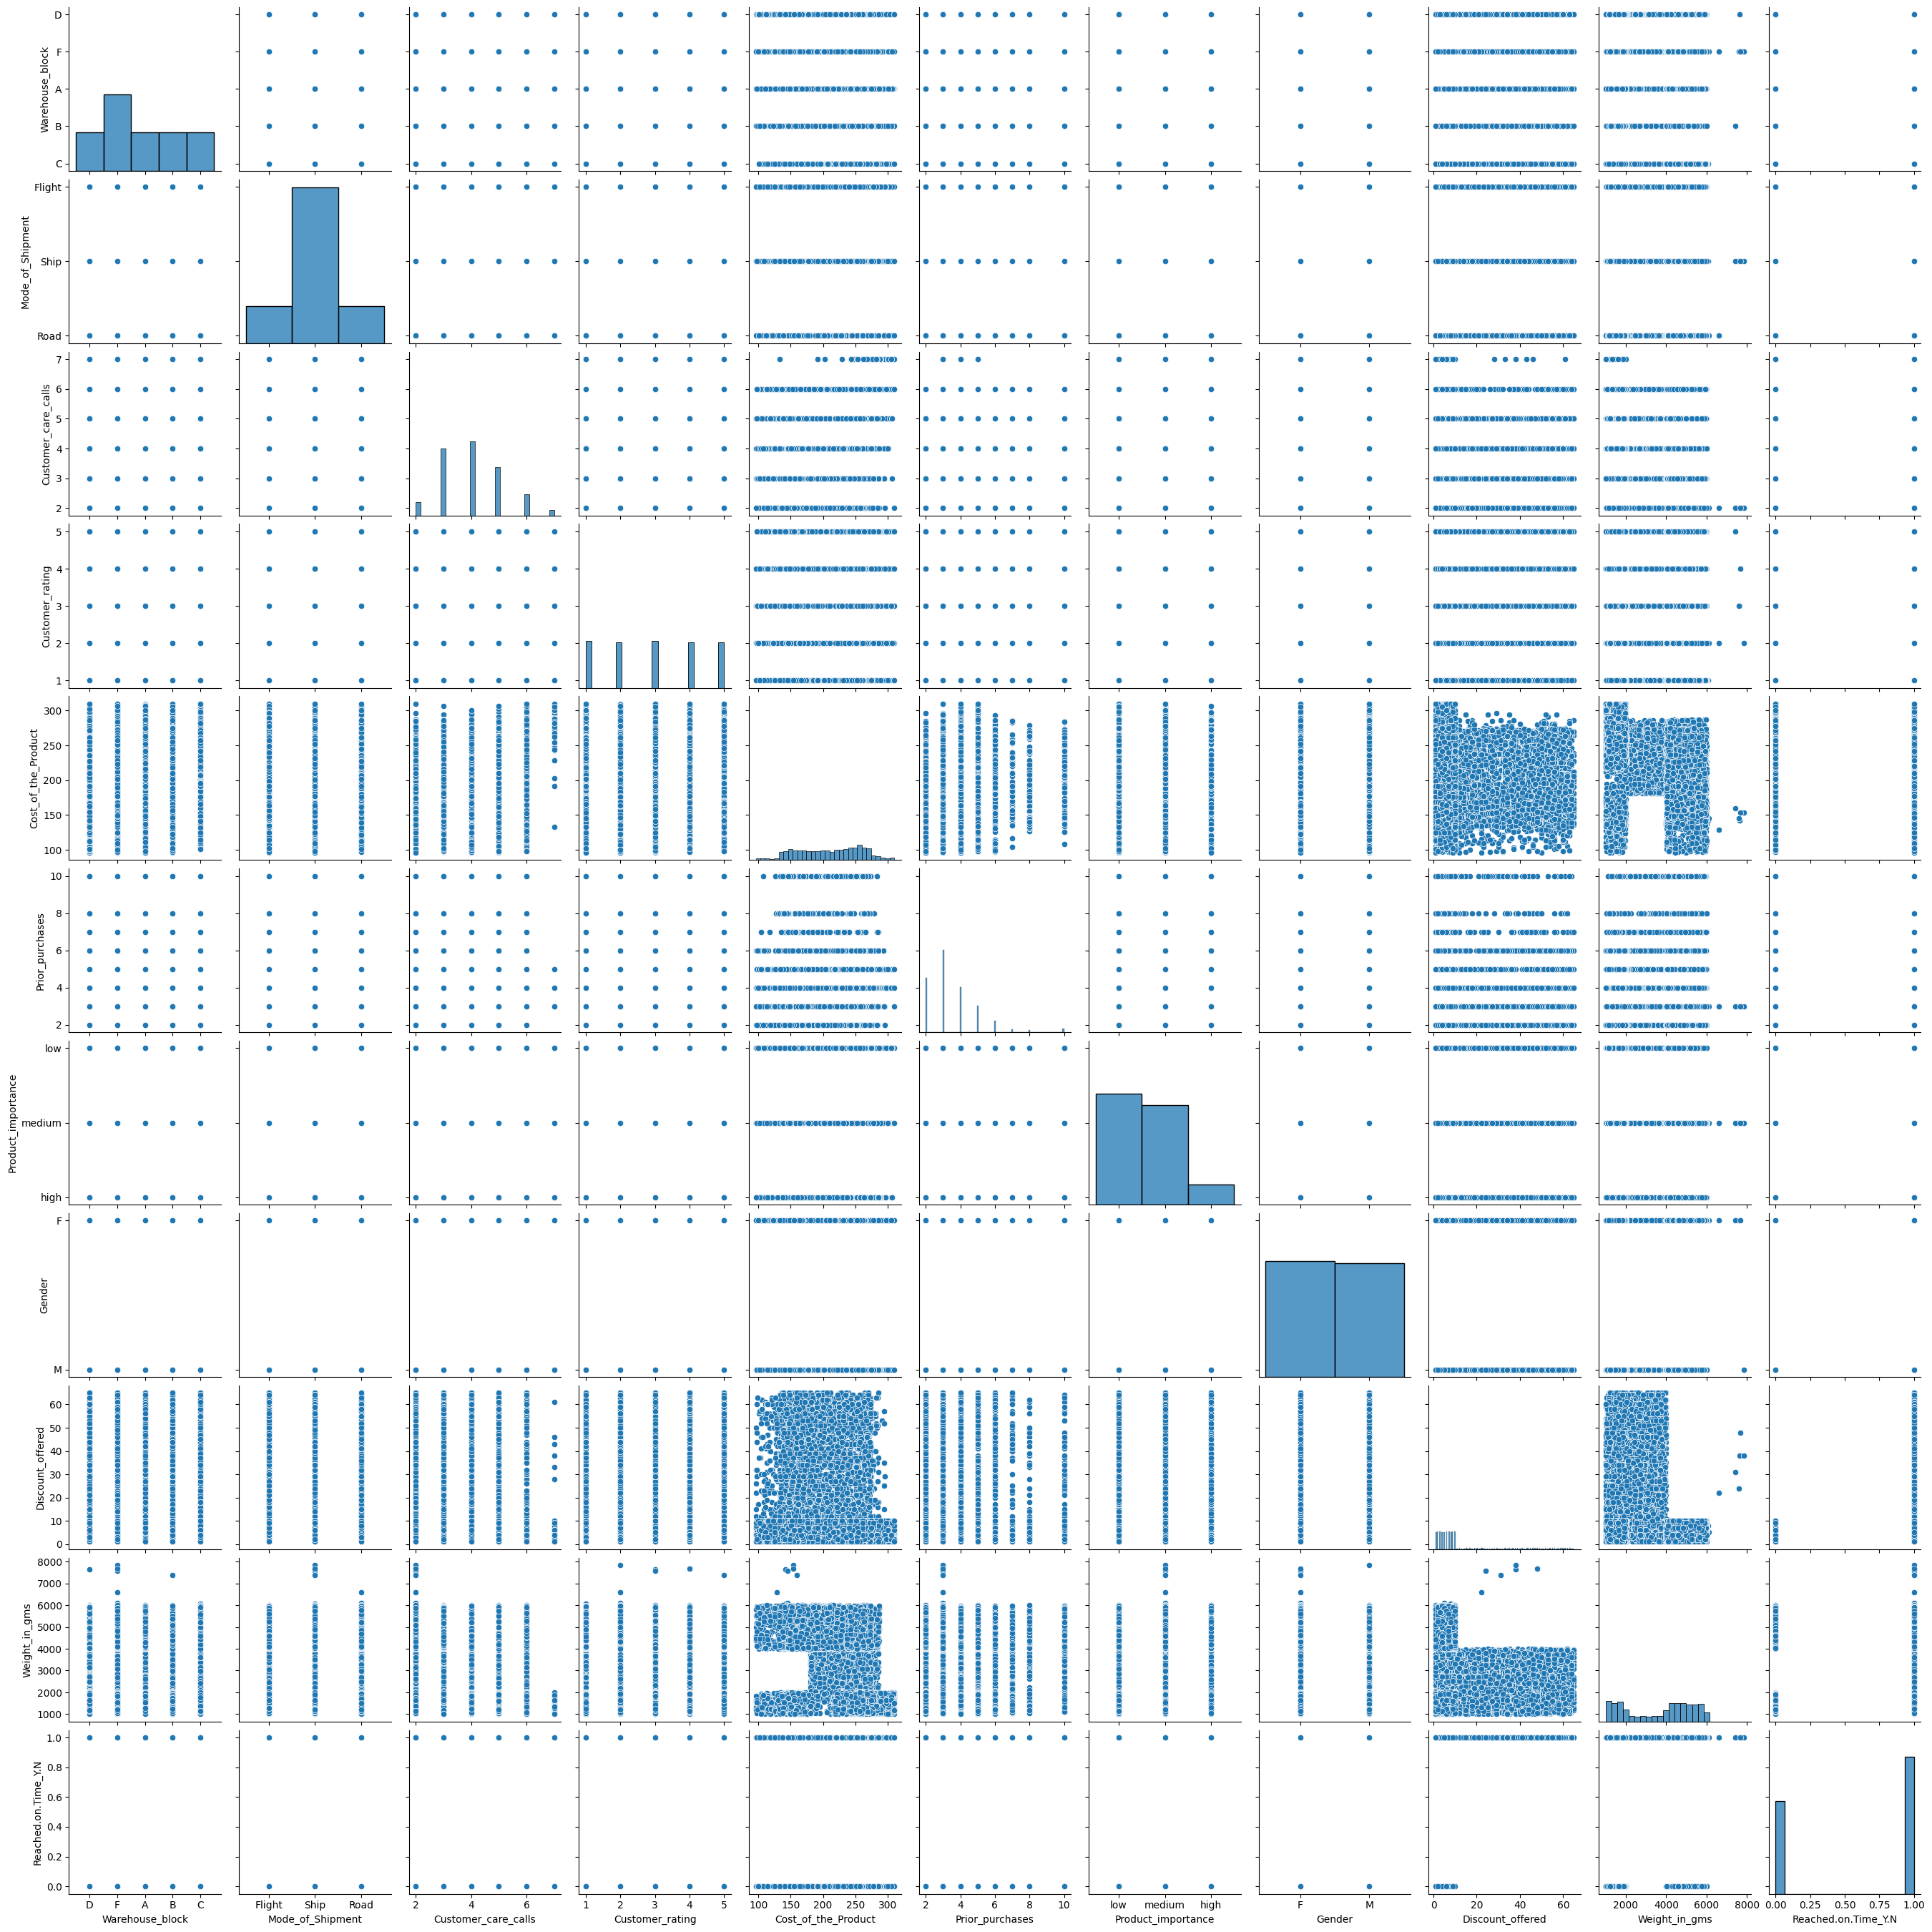

In [154]:
vars = df.columns
sns.pairplot(df, vars=vars)

plt.show()

### Correlation Matrix (One Hot Encoding)

As some variables are categorical and not ordinal one hot encoding was used to look at correlation. Overall this increases the number of variables from 11 to 20 and makes comparisons generally more difficult. 

Comparing the one hot encoded categorical data to variables outside the same category no significant trends appear. Since individual one-hot encoded categorical variables don't show strong trends they will be combined using label encoding and a more detailed analysis will be done on correlations in the next step.

<Axes: >

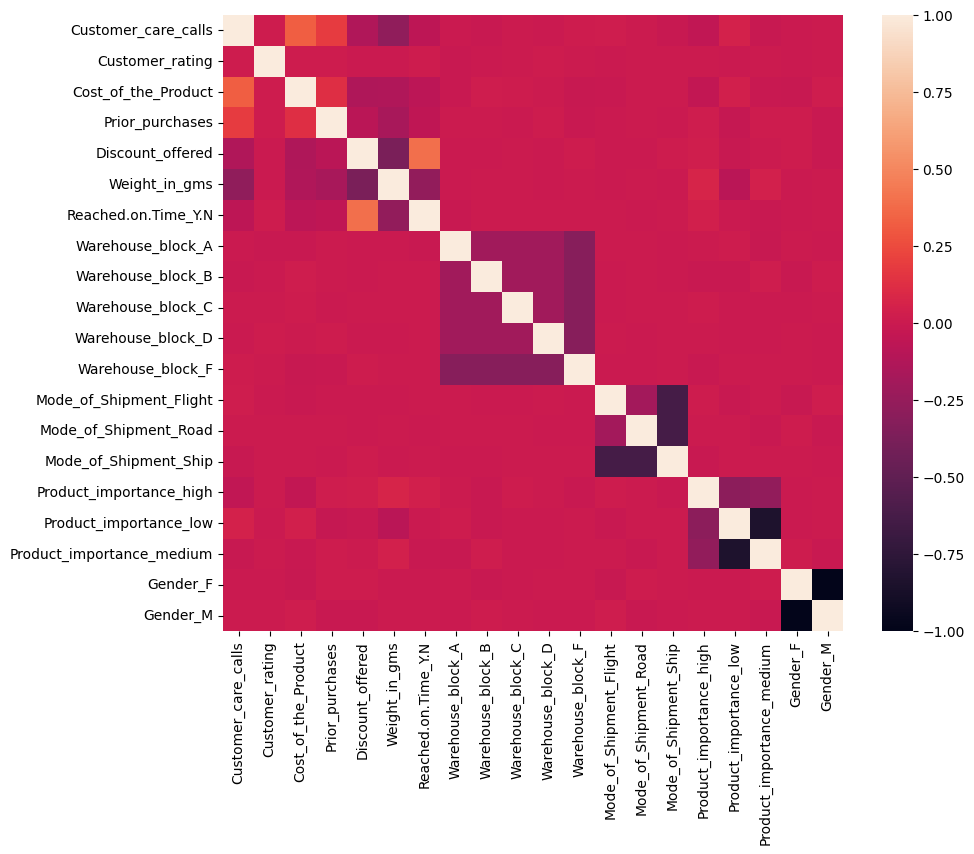

In [155]:
df_one_hot = pd.get_dummies(df)
plt.figure(figsize=(10, 8))
corr_one_hot = df_one_hot.corr()
sns.heatmap(corr_one_hot)

### Correlation Matrix (Label Encoding)

To keep the number of variables smaller label encoding was used to look at overall trends. In general a few significant trends were found. Using +/- 0.20 as an arbitrary cutoff the following correlations were observed:

- Discount Offered vs. Arrive on Time: This was the strongest trend at 0.40, indicating discount offered is going to be an important variable for models to use for preditions.
- Weight in Grams vs. Arrive on Time: Also a strong correlation with the target variable, lower product weights tend to arrive on time more often.
- Discount Offered vs. Weight in Grams: As the weight drops there is less likely to be a discount.
- Weight in Grams vs. Customer Care Calls: Higher weight means less customer care calls.
- Weight in Grams vs. Cost of Product: More heavy products tend to cost more, which intuitively makes sense.

All of these trends will be looked at in a more individual basis in the next section.

In [156]:

le = LabelEncoder()

df_label_encode = df.copy()

categorical_columns = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']

# Apply LabelEncoder to each categorical column
for col in categorical_columns:
    df_label_encode[col] = le.fit_transform(df_label_encode[col])

<Axes: >

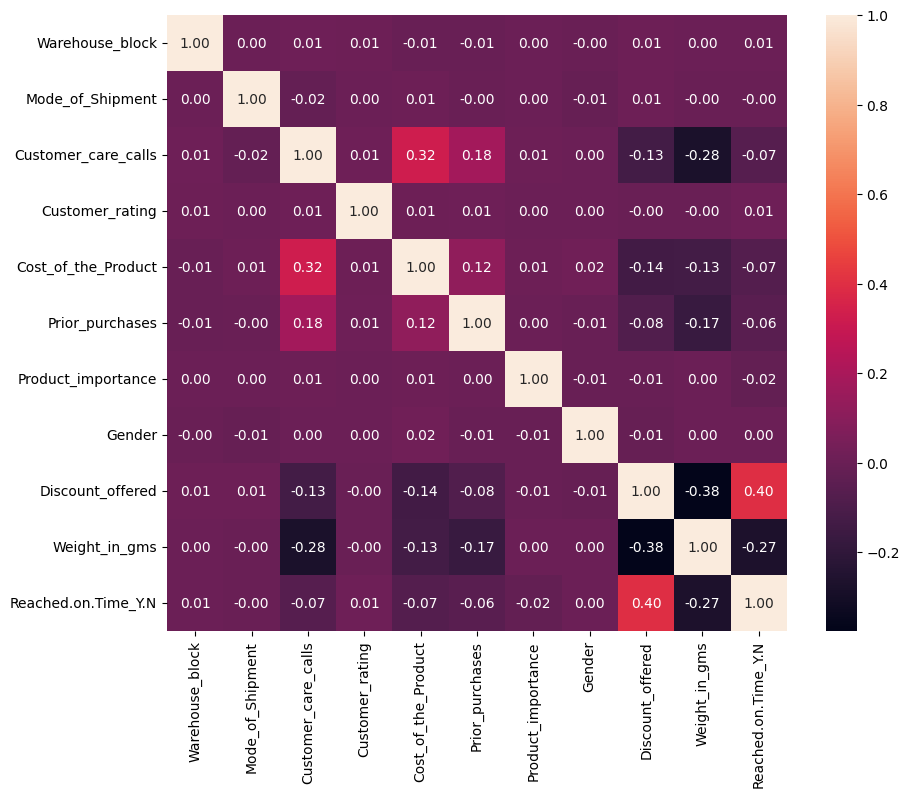

In [157]:
corr_label_encode = df_label_encode.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_label_encode, fmt='.2f', annot=True)

## Individual Correlations

A deeper look at the significant trends between variables.

### Discount Offered vs. Reached on Time

Products with higher discounts are much more likely to arrive on time. 

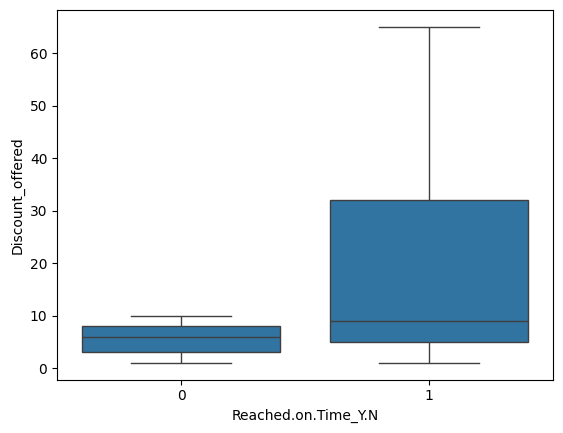

In [158]:
sns.boxplot(x=df[TARGET], y=df['Discount_offered'])
plt.show()

### Weight in Grams vs. Reached on Time

Comparing a boxplot shows the median value for weight of delayed shipments is higher, however there are a large number of low weight outliers, suggesting the data is bi-modal. 

Plotting the density shows that the weight in grams distribution is indeed bi-modal. What stands out is low weight products are more likely to arrive on time, and virtually no products between ~2.5 kg and ~3.5 kg are delayed.

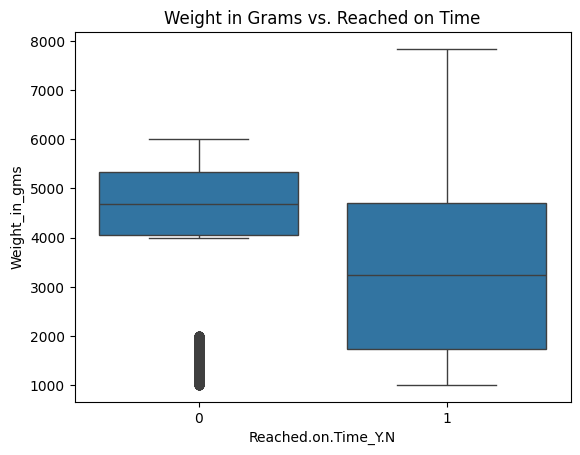

In [159]:
sns.boxplot(x=df[TARGET], y=df['Weight_in_gms'])
plt.title("Weight in Grams vs. Reached on Time")
plt.show()

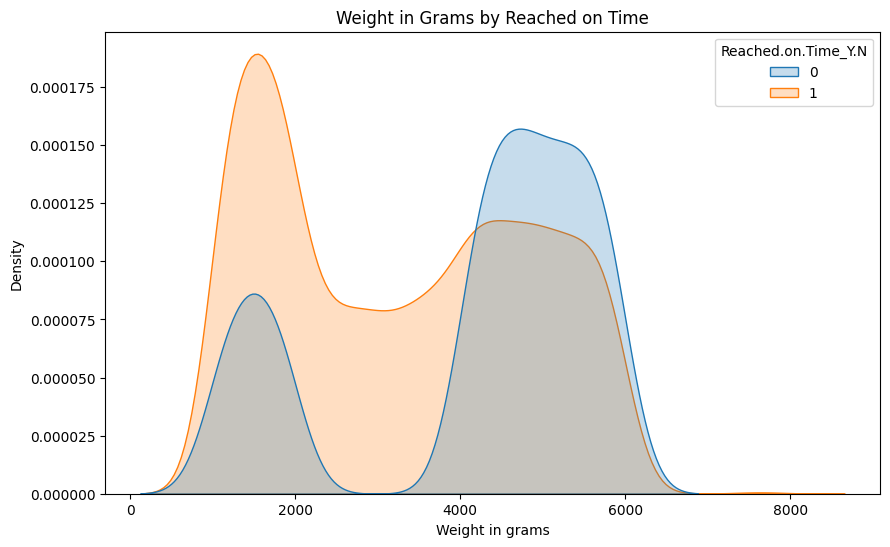

In [160]:
# Plot density plots
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='Weight_in_gms', hue=TARGET, fill=True)
plt.title('Weight in Grams by Reached on Time')
plt.xlabel('Weight in grams')
plt.ylabel('Density')
plt.show()

### Discount Offered vs. Weight in Grams

It seems like there are specific ranges for discounts based on weight:
- 1kg - 4kg: 0 - 65 % discount
- 4kg - 6kg: 0 - 10 % discount
- 6kg+ : Very few products and no trend

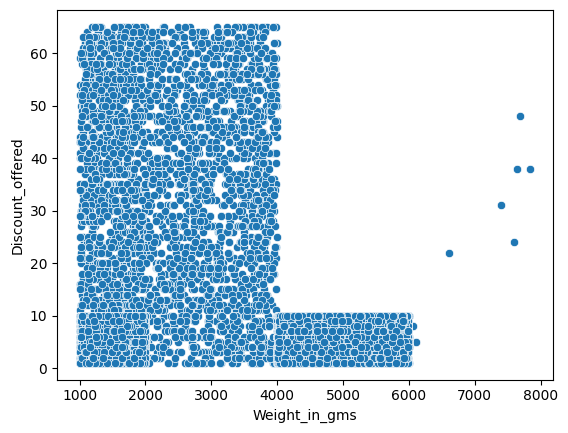

In [161]:
sns.scatterplot(data=df, x='Weight_in_gms', y='Discount_offered')
plt.show()

### Weight in Grams vs. Customer Care Calls

Lighter packages have less customer care calls. This is not expected, as heavier packages are more likely to be delayed.

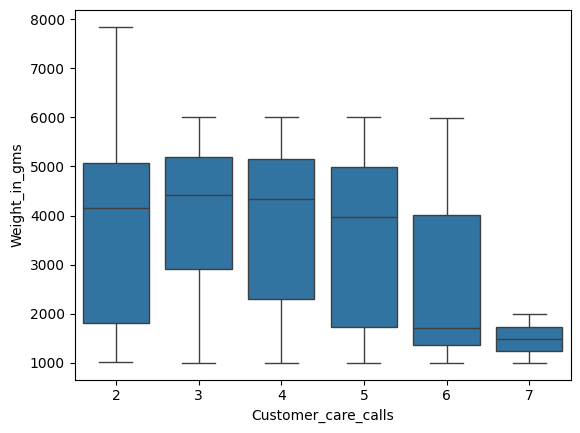

In [162]:
sns.boxplot(data=df, y='Weight_in_gms', x='Customer_care_calls')
plt.show()

### Cost of Product vs. Customer Care Calls

Higher cost products have more customer care calls as expected.

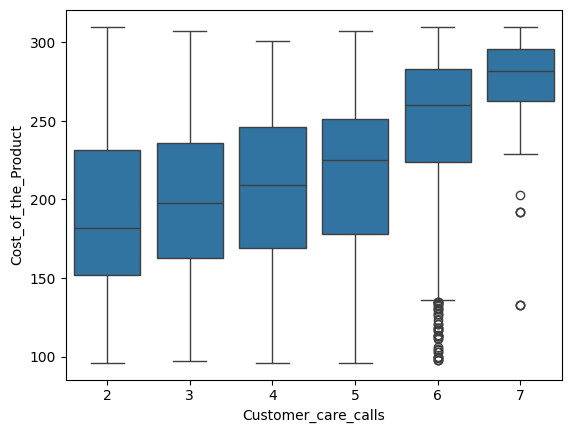

In [163]:
sns.boxplot(data=df, y='Cost_of_the_Product', x='Customer_care_calls')
plt.show()

## EDA Summary

Dataset Quality: 

- No missing values were found in the dataset. 
- Several variables are categorical requireing encoding, however significant feature engineering will not be necessary to process the data.
- Roughly even distribution between neg / pos classes with a 60/40 split.

Key Correlations with Target Variable: 

- Discount Offered vs. Arrive on Time: Products are much more likely to arrive on-time if a discount is offered.
- Weight in Grams vs. Arrive on Time: Lower product weights tend to arrive on time more often.

# Part II: Data Cleaning, Preparation and Feature Engineering

During EDA, it was observed that the dataset was relativey clean and free of missing values.  However, it was also observed that several categorical features were present, which will need to be encoded to make them understandable to the models downstream.  There are also several numerical/continuous variables present, which will require normalization.  With this in mind, the following data preparation tasks will be conducted:

- Drop columns unnecessary for modeling (ie: ID)
- One-Hot encode categorical variables
- Ordinally encode ordinal categorical variables
- Separate target variable from features
- Perform train/test/val split at 80/10/10
- Normalize continuous variables

It should be noted that the normalization scaler was fit to the training dataset only to avoid data leakage.  The trained scaler was then applied to the three resulting data sets: train/test/val

## Setup

### Split X and y features

In [583]:
# separate features from target
X = df.drop(columns=TARGET)
y = df[TARGET]

### Encode Categorical Features

There are several categorical features present in the dataset that must be encoded for use by any downstream models.  These features will be one-hot encoded.  Since Product Importance represents an ordinal feature, this feature will be ordinally encoded with label encoding.


In [584]:
# label encode the product_importance column since it is ordinal
le = LabelEncoder()

X_encoded = X.copy()

categorical_columns = ['Product_importance']

# Apply LabelEncoder to each categorical column
for col in categorical_columns:
    X_encoded[col] = le.fit_transform(X_encoded[col])

In [585]:
# inspect the results
X_encoded.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms
0,D,Flight,4,2,177,3,1,F,44,1233
1,F,Flight,4,5,216,2,1,M,59,3088
2,A,Flight,2,2,183,4,1,M,48,3374
3,B,Flight,3,3,176,4,2,M,10,1177
4,C,Flight,2,2,184,3,2,F,46,2484


In [586]:
# one hot encode the remaining categorical features
X_encoded = pd.get_dummies(X_encoded)

In [587]:
# inspect results
X_encoded.head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Discount_offered,Weight_in_gms,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Gender_F,Gender_M
0,4,2,177,3,1,44,1233,0,0,0,1,0,1,0,0,1,0
1,4,5,216,2,1,59,3088,0,0,0,0,1,1,0,0,0,1
2,2,2,183,4,1,48,3374,1,0,0,0,0,1,0,0,0,1
3,3,3,176,4,2,10,1177,0,1,0,0,0,1,0,0,0,1
4,2,2,184,3,2,46,2484,0,0,1,0,0,1,0,0,1,0


### Perform Train/Test Split

Split the prepared dataset into train/test/val datasets for use by modeling in next stages.  Implement an 80/10/10 split.

In [588]:
# split the data into train and test sets (80% and 20%)
X_train, X_test_val, y_train, y_test_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# split the test_val into test and val sets (10% and 10%)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

In [589]:
np.unique(y, return_counts = True)

(array([0, 1]), array([4436, 6563]))

In [590]:
np.unique(y_test_val, return_counts = True)

(array([0, 1]), array([ 895, 1305]))

In [591]:
np.unique(y_test, return_counts = True)

(array([0, 1]), array([450, 650]))

### Normalize Continuous Numerical Features

For the remaining continuous features, a scaler will be fit to the dataset to normalize the numerical range

In [592]:
#list for cols to scale
cols_to_scale = ['Cost_of_the_Product', 'Discount_offered', 'Weight_in_gms', 'Prior_purchases', 'Customer_care_calls']

#create and fit scaler using X train set
scaler = StandardScaler()
scaler.fit(X_train[cols_to_scale])

#scale X train, test, val data
X_train[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
X_val[cols_to_scale] = scaler.transform(X_val[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

### Write prepared data to file for use by modeling experiments

In [593]:
# train data
X_train.to_csv('./data/x_train.csv', index=False)
y_train.to_csv('./data/y_train.csv', index=False)

# test data
X_test.to_csv('./data/x_test.csv', index=False)
y_test.to_csv('./data/y_test.csv', index=False)

# val data
X_val.to_csv('./data/x_val.csv', index=False)
y_val.to_csv('./data/y_val.csv', index=False)

# Part III-A: Modeling - Logistic Regression, KNN, RandomForest

## Load Preprocessed Data

Note: This is only done once for the first model and used throughout the notebook.

In [596]:
# train data
X_train = pd.read_csv('./data/x_train.csv')
y_train = np.ravel(pd.read_csv('./data/y_train.csv'))

# val data
X_val = pd.read_csv('./data/x_val.csv')
y_val = np.ravel(pd.read_csv('./data/y_val.csv'))

In [597]:
# Check imported data
print('TRAIN SET:')
print('   X_train:', X_train.shape)
print('   y_train:', y_train.shape)
print('\nVALIDATION SET:')
print('   X_val:', X_val.shape)
print('   y_val:', y_val.shape)

TRAIN SET:
   X_train: (8799, 17)
   y_train: (8799,)

VALIDATION SET:
   X_val: (1100, 17)
   y_val: (1100,)


In [600]:
X_train.head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Discount_offered,Weight_in_gms,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Gender_F,Gender_M
0,-0.925605,5,-0.670120,-0.378680,1,-0.392911,0.311901,0,0,0,0,1,0,0,1,1,0
1,1.697108,3,-0.173246,0.273631,2,-0.638968,0.532606,1,0,0,0,0,0,0,1,1,0
2,-1.799843,5,1.379486,-0.378680,2,-0.454426,-1.585178,0,0,0,1,0,0,0,1,0,1
3,0.822870,5,0.178707,-1.030992,2,-0.577454,0.406052,0,0,1,0,0,0,0,1,0,1
4,1.697108,3,1.772845,0.273631,1,-0.577454,-1.207352,0,0,1,0,0,1,0,0,1,0


In [601]:
X_val.head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Discount_offered,Weight_in_gms,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Gender_F,Gender_M
0,-0.051367,2,1.213861,-1.030992,2,-0.700483,0.237314,0,0,0,1,0,0,1,0,1,0
1,-0.051367,2,-0.421683,-0.378680,2,-0.392911,0.697675,1,0,0,0,0,0,1,0,0,1
2,-0.051367,1,-0.297464,-1.030992,1,-0.638968,0.689116,0,0,0,1,0,0,0,1,0,1
3,-0.925605,3,-0.152543,-0.378680,2,-0.392911,0.826674,0,0,0,1,0,1,0,0,0,1
4,0.822870,5,0.779096,0.925943,2,-0.331397,-1.066126,1,0,0,0,0,1,0,0,0,1


In [602]:
# create a list of tuned models for comparison
tuned_models=list([None]*7)

# create a list of predicted values 
pred_values = list([np.zeros(len(X_val))]*7)

## Model 1: Logistic Regression

A simple Logistic Regression is used to establish a baseline performance. 
Default parameter values are used.

### Model 1: Create, Train Model

In [603]:
# create model instance
model1 = []
model1 = LogisticRegression(solver='liblinear', random_state=0)

#fit the model using the training data
model1.fit(X_train, y_train)


LogisticRegression(random_state=0, solver='liblinear')

### Model 1: Describe/Visualize Model

In [604]:
model1_featcoeff = pd.DataFrame({ 'features': model1.feature_names_in_,
                                  'coef' : np.ravel(model1.coef_)})

model1_featcoeff.set_index('features').sort_values('coef')

,coef
features,
Weight_in_gms,-0.380287
Customer_care_calls,-0.127812
Prior_purchases,-0.122080
Cost_of_the_Product,-0.109246
Product_importance,-0.096254
Customer_rating,0.022963
Warehouse_block_A,0.027294
Warehouse_block_D,0.091684
Warehouse_block_F,0.099142


Holding other features constant, **Discount_offered** contributes the most to timely arrival of shipments while **Weight_in_gms** contributes the most to late arrival. This is consistent with our EDA analysis (section 'General Correlation between Variables')

### Model 1: Performance on Validation Set

In [605]:
# predict y values based on the validation set
y_pred1 = model1.predict(X_val)

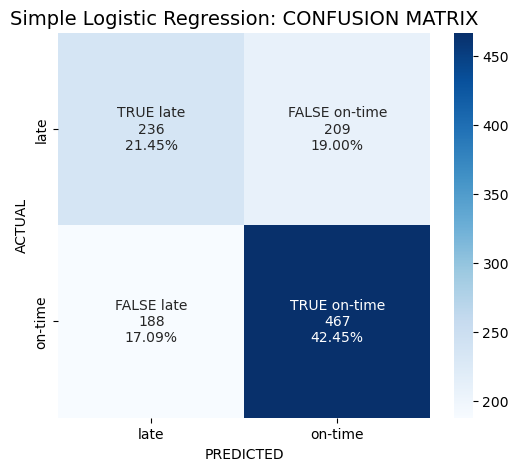

In [606]:
# generate confusion matrix for model1
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred1, title = 'Simple Logistic Regression')

In [607]:
# Generate Classification Report for model 1
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred1, title = 'Simple Logistic Regression')
    

Simple Logistic Regression: CLASSIFICATION REPORT

              precision    recall  f1-score   support

        late       0.56      0.53      0.54       445
     on-time       0.69      0.71      0.70       655

    accuracy                           0.64      1100
   macro avg       0.62      0.62      0.62      1100
weighted avg       0.64      0.64      0.64      1100



In [608]:
# save model for comparison
tuned_models[0] = model1

# save predicted values
pred_values[0] = y_pred1

## Model 2: K Nearest Neighbor

....

### Model 2: Create, train, evaluate as many KNN models as there are K-values

In [609]:
k_values = list(range(1, 20))
acc_train = []
acc_val = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    
    knn.fit(X_train, y_train)
    
    y_pred_train = knn.predict(X_train)
    
    y_pred_val = knn.predict(X_val)
    
    acc_train.append(accuracy_score(y_train, y_pred_train))
    acc_val.append(accuracy_score(y_val, y_pred_val))

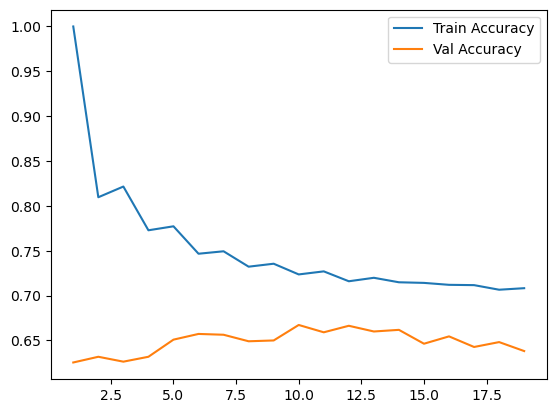

In [610]:
plt.plot(k_values, acc_train, label = 'Train Accuracy')
plt.plot(k_values, acc_val, label = 'Val Accuracy')
plt.legend()


In [611]:
# select k_value with highest Validation accuracy

k_best = acc_val.index(max(acc_val))
k_best

9

In [612]:
# generate kNN model (again) using n_neighbors that gave the highest validation accuraxy

model2 = KNeighborsClassifier(n_neighbors=k_best)
    
model2.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

### Model 2: Performance on Validation Set

In [613]:
# predict y values based on the validation set
y_pred2 = model2.predict(X_val)

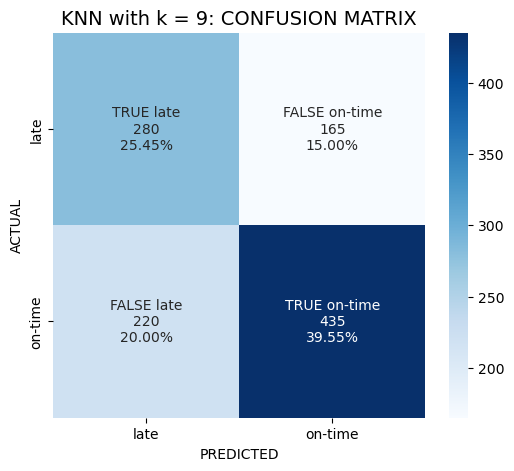

In [614]:
# generate confusion matrix for model2
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred2, title = f'KNN with k = {k_best}')

In [615]:
# Generate Classification Report for model 2
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred2, title = f'KNN with k = {k_best}')

KNN with k = 9: CLASSIFICATION REPORT

              precision    recall  f1-score   support

        late       0.56      0.63      0.59       445
     on-time       0.72      0.66      0.69       655

    accuracy                           0.65      1100
   macro avg       0.64      0.65      0.64      1100
weighted avg       0.66      0.65      0.65      1100



In [616]:
# tuning
# initialize model
model2_tune = KNeighborsClassifier()

# setup search grid
k_values = list(range(1, 20))

param2_grid = { 
    'n_neighbors' : k_values,
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [30, 20, 40, 10, 50]
}


In [617]:
# run search
CV_knn = GridSearchCV(estimator=model2_tune, param_grid=param2_grid, cv=5, verbose=1, n_jobs=-1)
CV_knn.fit(X_train, y_train)

Fitting 5 folds for each of 285 candidates, totalling 1425 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [30, 20, 40, 10, 50],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19]},
             verbose=1)

In [618]:
# display best found hyperparamater combination
CV_knn.best_params_

{'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 19}

In [619]:
# get best model
model2_tune_best = CV_knn.best_estimator_

In [620]:
# predict y values based on the validation set using best model
y_pred2_tuned = model2_tune_best.predict(X_val)

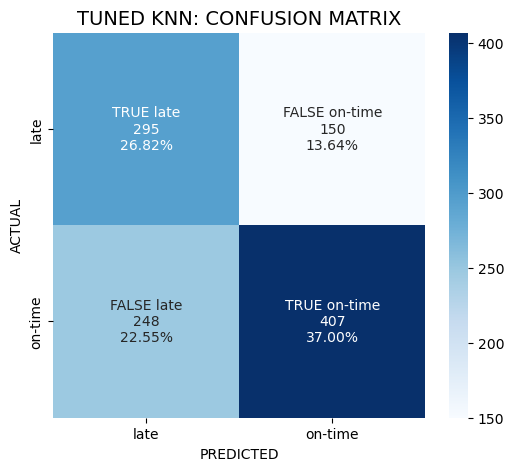

In [621]:
# generate confusion matrix for tuned model 2
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred2_tuned, title ='TUNED KNN')

In [622]:
# Generate Classification Report for tuned model 2
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred2_tuned, title = 'TUNED KNN')

TUNED KNN: CLASSIFICATION REPORT

              precision    recall  f1-score   support

        late       0.54      0.66      0.60       445
     on-time       0.73      0.62      0.67       655

    accuracy                           0.64      1100
   macro avg       0.64      0.64      0.63      1100
weighted avg       0.65      0.64      0.64      1100



In [623]:
# save model for comparison
tuned_models[1] = model2_tune_best

# save predicted values
pred_values[1] = y_pred2_tuned

## Model 3: Random Forest

....

### Model 3: Create, train, etc

In [624]:
model3 = RandomForestClassifier(max_depth=3, random_state=0)
model3.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, random_state=0)

In [625]:
# predict y values based on the validation set
y_pred3 = model3.predict(X_val)

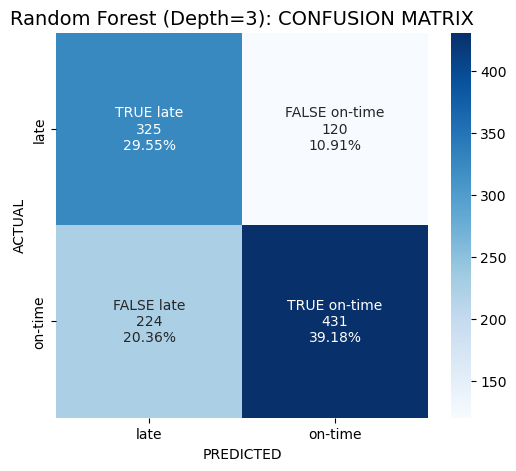

In [626]:
# generate confusion matrix for model2
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred3, title = 'Random Forest (Depth=3)')

In [627]:
# Generate Classification Report for model 3
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred3, title = 'Random Forest (Depth=3)')

Random Forest (Depth=3): CLASSIFICATION REPORT

              precision    recall  f1-score   support

        late       0.59      0.73      0.65       445
     on-time       0.78      0.66      0.71       655

    accuracy                           0.69      1100
   macro avg       0.69      0.69      0.68      1100
weighted avg       0.71      0.69      0.69      1100



In [628]:
#hyper parameter tuning

# initialize model
model3_tune = RandomForestClassifier(random_state=0)

# setup search grid
param_grid = { 
    'max_depth': [3, 5, 7, 9],
    'min_samples_leaf': [2, 3, 4, 5, 7],
    'criterion' :['gini', 'entropy', 'log_loss']
}

In [629]:
# run search
CV_rf = GridSearchCV(estimator=model3_tune, param_grid=param_grid, cv=5, verbose=1, n_jobs=1)
CV_rf.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 5, 7, 9],
                         'min_samples_leaf': [2, 3, 4, 5, 7]},
             verbose=1)

In [630]:
# display best found hyperparamater combination
CV_rf.best_params_

{'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 4}

In [631]:
# get best model
model3_tune_best = CV_rf.best_estimator_

In [632]:
# predict y values based on the validation set using best model
y_pred3_tuned = model3_tune_best.predict(X_val)

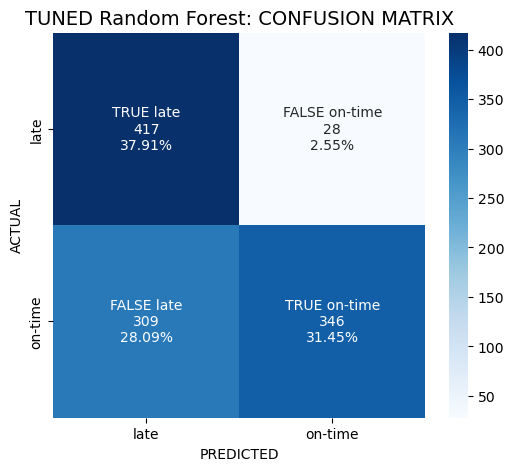

In [634]:
# generate confusion matrix for tuned model 3
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred3_tuned, title ='TUNED Random Forest')

In [635]:
# Generate Classification Report for tuned model 3
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred3_tuned, title = 'TUNED Random Forest')

TUNED Random Forest: CLASSIFICATION REPORT

              precision    recall  f1-score   support

        late       0.57      0.94      0.71       445
     on-time       0.93      0.53      0.67       655

    accuracy                           0.69      1100
   macro avg       0.75      0.73      0.69      1100
weighted avg       0.78      0.69      0.69      1100



In [636]:
# save model for comparison
tuned_models[2] = model3_tune_best

# save predicted values
pred_values[2] = y_pred3_tuned

# Part III-B: Modeling - Naive Bayes Classifier, Support Vector Machine

## Model 1: Naive Bayes Classifier

Naive Bayes was chosen as a simple model that could perform binary classification on our dataset.

### Naive Bayes Classifier Baseline - No Tuning

In [637]:
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)

GaussianNB()

### Model 1: Performance on Validation Set

In [638]:
# predict y values based on the validation set
y_pred1 = gnb_model.predict(X_val)

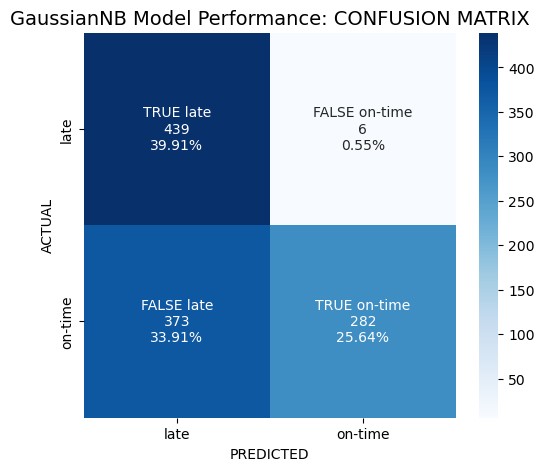

In [639]:
# generate confusion matrix for model1
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred1, title = 'GaussianNB Model Performance')

In [640]:
# Generate Classification Report for model 1
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred1, title = 'GaussianNB')
    

GaussianNB: CLASSIFICATION REPORT

              precision    recall  f1-score   support

        late       0.54      0.99      0.70       445
     on-time       0.98      0.43      0.60       655

    accuracy                           0.66      1100
   macro avg       0.76      0.71      0.65      1100
weighted avg       0.80      0.66      0.64      1100



### Naive Bayes Classifier Baseline Results

Overall accuracy is similar to other models at 0.66, or roughly two thirds of the time correctly predicting a shipment status. However the confusion matrix shows that model is strongly biased towards identifying late shipments correctly, even at the expense of a high false alarm rate for on-time shipments that are falsely labeled as late. This particular classifier would be useful in a situation where there is no tolerance for missing positives and minimal drawback for false positives, such as a fraud detection scenario.

### Naive Bayes Classifier - Tuning

In [641]:
gnb_model_tune = GaussianNB()

In [642]:
# Define the parameter grid
gnb_param_grid = {
    'var_smoothing': [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11]  # Smoothing parameter
}

In [643]:
gnb_grid_search = GridSearchCV(estimator=gnb_model_tune, param_grid=gnb_param_grid, scoring='accuracy', verbose=1, n_jobs=-1)

In [644]:
gnb_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [0.001, 0.0001, 1e-05, 1e-06, 1e-07,
                                           1e-08, 1e-09, 1e-10, 1e-11]},
             scoring='accuracy', verbose=1)

In [645]:
# Print the best parameters and best score
print("Best Parameters:", gnb_grid_search.best_params_)
print("Best Score:", gnb_grid_search.best_score_)

Best Parameters: {'var_smoothing': 1e-05}
Best Score: 0.6496204584216239


In [646]:
gnb_best_model = gnb_grid_search.best_estimator_
y_pred1_tuned = gnb_best_model.predict(X_val)

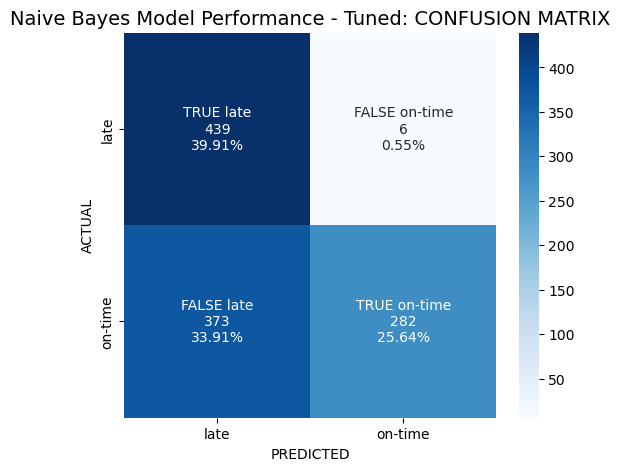

In [647]:
# generate confusion matrix for model1
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred1_tuned, title = 'Naive Bayes Model Performance - Tuned')

In [648]:
# Generate Classification Report for model 1 Tuned
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred1_tuned, title = 'Naive Bayes - Tuned Hyperparameters')

Naive Bayes - Tuned Hyperparameters: CLASSIFICATION REPORT

              precision    recall  f1-score   support

        late       0.54      0.99      0.70       445
     on-time       0.98      0.43      0.60       655

    accuracy                           0.66      1100
   macro avg       0.76      0.71      0.65      1100
weighted avg       0.80      0.66      0.64      1100



### Naive Bayes Classifier Tuned Results

Attempting to tune the smoothing parameter for the Naive Bayes Classifier does not significantly change the outcome of the model. Overall it is still biased towards identifying the positive class at the expense of false positives. This is shown by high recall on the late class (identifying late shipments) with low precision on the late class (high false alarm rate). While Naive Bayes gives good overall accuracy compared to other models it does heavily weight the positive class results.

In [649]:
# save model for comparison
tuned_models[3] = gnb_best_model

# save predicted values
pred_values[3] = y_pred1_tuned

## Model 2: Support Vector Machine (SVM)

A support vector classifier is a common technique for classifying data by splitting it into a linearly seperable set of classes in a high dimensional space. While it is particularly well suited for high dimensional data it was evaluated on this dataset as a potential binary classifier.

### Model 2: SVC Baseline - No Tuning

In [650]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

### Model 2: Performance on Validation Set

In [651]:
# predict y values based on the validation set
y_pred2 = svm_model.predict(X_val)
y_pred2

array([0, 0, 0, ..., 0, 0, 0])

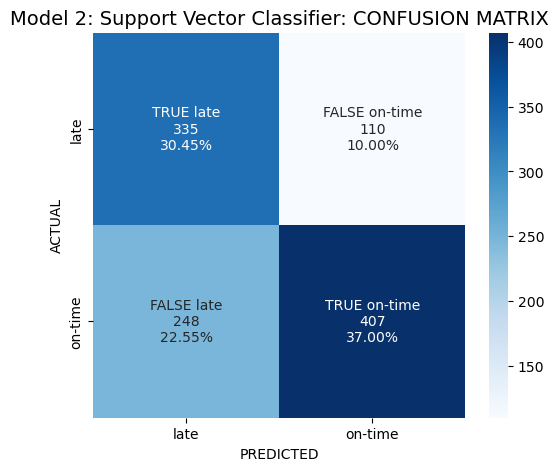

In [652]:
# generate confusion matrix for model2
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred2, title = 'Model 2: Support Vector Classifier')

In [653]:
# Generate Classification Report for model 2
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred2, title = 'Model 2: Support Vector Classifier')

Model 2: Support Vector Classifier: CLASSIFICATION REPORT

              precision    recall  f1-score   support

        late       0.57      0.75      0.65       445
     on-time       0.79      0.62      0.69       655

    accuracy                           0.67      1100
   macro avg       0.68      0.69      0.67      1100
weighted avg       0.70      0.67      0.68      1100



### SVC Baseline Results

While the Support Vector Classifier gives the same rough accuracy as the other models at 67%, it shows more moderation between identifying positive examples and giving false alarms. The overal f1 score for late examples is 0.65 while the f1 score for on-time examples is 0.69, showing that the model is still biased towards identifying late shipments. However compared to Naive Bayes as an example the bias is less, with lower differences between precision and recall in the same class.

### SVC Tuning

In [654]:
svc_model_tune = SVC()

In [655]:
svc_param_grid = {
    'C': [0.01, .1, 1, 10],   # Regularization: Low C = high bias, low variance
    'gamma': [0.001, 0.01, 0.1, 1],  # High means focusing more on points close to decision boundary, low is smoother boundary
    'kernel': ['linear', 'rbf']   # Kernel type: Linear good for simple linearly seperable, otherwise radial basis function
}

In [656]:
svc_grid_search = GridSearchCV(estimator=svc_model_tune, param_grid=svc_param_grid, scoring='accuracy', verbose=1, n_jobs=-1)
svc_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=1)

In [657]:
# Print the best parameters and best score
print("Best Parameters:", svc_grid_search.best_params_)
print("Best Score:", svc_grid_search.best_score_)

Best Parameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Best Score: 0.6633724611091012


In [658]:
svc_best_model = svc_grid_search.best_estimator_
y_pred2_tuned = svc_best_model.predict(X_val)

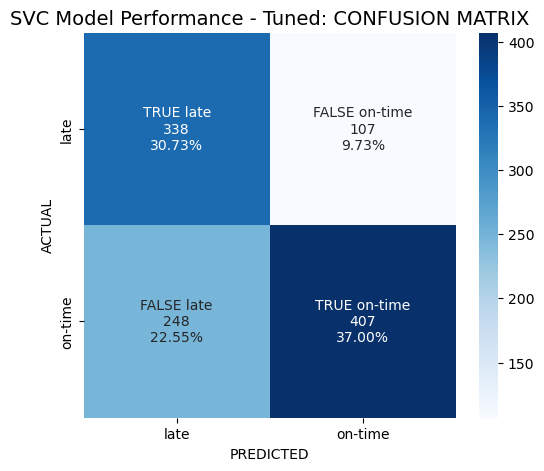

In [659]:
# generate confusion matrix for model1
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred2_tuned, title = 'SVC Model Performance - Tuned')

In [660]:
# Generate Classification Report for model 2 Tuned
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred2_tuned, title = 'Support Vector Classifier - Tuned Hyperparameters')

Support Vector Classifier - Tuned Hyperparameters: CLASSIFICATION REPORT

              precision    recall  f1-score   support

        late       0.58      0.76      0.66       445
     on-time       0.79      0.62      0.70       655

    accuracy                           0.68      1100
   macro avg       0.68      0.69      0.68      1100
weighted avg       0.70      0.68      0.68      1100



### SVC Tuning Set 2

In [661]:
svc_model_tune_2 = SVC()

In [662]:
svc_param_grid_2 = {
    'C': [0.02, 0.05, .1, 0.2, 0.5],   # Regularization: Low C = high bias, low variance
    'gamma': [0.002, 0.005, 0.01, 0.02, 0.05],  # High means focusing more on points close to decision boundary, low is smoother boundary
    'kernel': ['rbf']   # Kernel type: Linear good for simple linearly seperable, otherwise radial basis function
}

In [663]:
svc_grid_search_2 = GridSearchCV(estimator=svc_model_tune_2, param_grid=svc_param_grid_2, scoring='accuracy', verbose=1, n_jobs=-1)
svc_grid_search_2.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.02, 0.05, 0.1, 0.2, 0.5],
                         'gamma': [0.002, 0.005, 0.01, 0.02, 0.05],
                         'kernel': ['rbf']},
             scoring='accuracy', verbose=1)

In [664]:
# Print the best parameters and best score
print("Best Parameters:", svc_grid_search_2.best_params_)
print("Best Score:", svc_grid_search_2.best_score_)

Best Parameters: {'C': 0.05, 'gamma': 0.02, 'kernel': 'rbf'}
Best Score: 0.6642816166210139


In [665]:
svc_best_model_2 = svc_grid_search_2.best_estimator_
y_pred3_tuned = svc_best_model_2.predict(X_val)

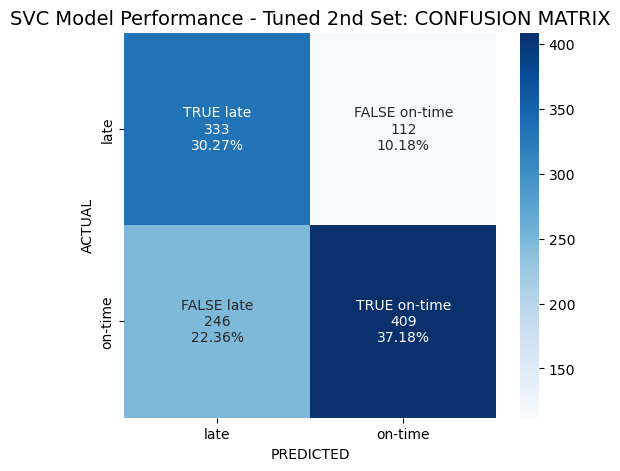

In [666]:
# generate confusion matrix for model1
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred3_tuned, title = 'SVC Model Performance - Tuned 2nd Set')

In [667]:
# Generate Classification Report for model 3 Tuned
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred3_tuned, title = 'Support Vector Classifier - Tuned Hyperparameters 2nd Set')

Support Vector Classifier - Tuned Hyperparameters 2nd Set: CLASSIFICATION REPORT

              precision    recall  f1-score   support

        late       0.58      0.75      0.65       445
     on-time       0.79      0.62      0.70       655

    accuracy                           0.67      1100
   macro avg       0.68      0.69      0.67      1100
weighted avg       0.70      0.67      0.68      1100



In [668]:
# save model for comparison
tuned_models[4] = svc_best_model_2

# save predicted values
pred_values[4] = y_pred3_tuned

### SVC Tuned Results

In order to tune the SVC model a few different hyperparameters were considered. The first parameter selected was 'C', which controls the degree of regularization, with lower values giving lower variance. Next was gamma, with lower values giving a smoother decision boundary. Finally both a basic linear function and rbf (radial basis function) were evaluated for kernels.

Based on the parameter tuning results both low C and gamma values coupled with a radial basis function for the kernels were found to be optimal.This indicates that aggresive regularization (high bias, low variance) along with a smoother decision boundary tended to perform the best. Both of these settings would prevent the model from overfitting to the training dataset against the validation dataset. The use of the radial basis function indicates that the model benefited from a more complex kernal to translate the data into a lineraly seperable space.

However the overall scores and balance is similar between the tuned and baseline models, indicating hyperparameter tuning does not have a significant effect for SVC results on the shipping dataset.

# Part III-C: Modeling - Decision Tree, XGBoost

## Model 1: Decision Tree Classifier

Decision Tree classifier to predict on-time shipments.

### Model 1: Create, Train Model

Start with some standard hyperparameters to initialize the model as a baseline

In [669]:
# Decision Tree helper functions
def plot_feature_importance(dt, columns):
    feat_importance = dt.tree_.compute_feature_importances(normalize=False)
    #feat_importance_df = pd.DataFrame(feat_importance.reshape(1,-1), columns=list(X_train))
    feat_importance_df = pd.Series(feat_importance, index=columns)

    # plot feature importances
    fig, ax = plt.subplots(figsize=(18, 6))
    feat_importance_df.plot.bar(ax=ax)
    ax.set_title("Feature importances")
    ax.set_ylabel("Importance")
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

In [670]:
dt_model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=2, criterion='entropy')
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=2)

### Model 1: Describe/Visualize Model

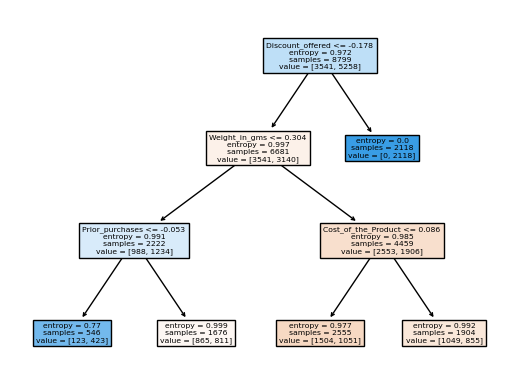

In [671]:
# visualize the tree generated
f_names=list(X_train.columns) 
tree.plot_tree(dt_model, filled=True, feature_names=f_names) 
plt.show() 

### Model 1: Performance on Validation Set

In [672]:
# predict y values based on the validation set
y_pred1 = dt_model.predict(X_val)

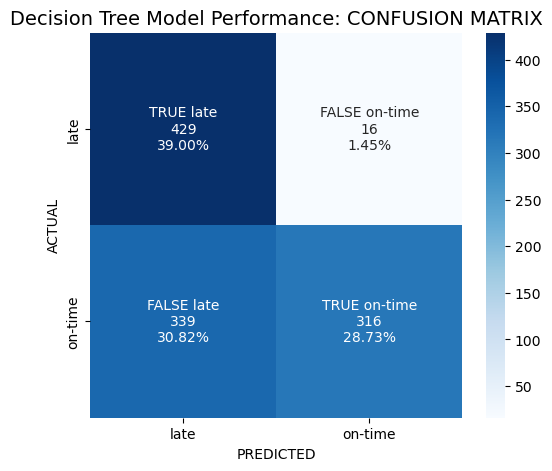

In [673]:
# generate confusion matrix for model1
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred1, title = 'Decision Tree Model Performance')

In [674]:
# Generate Classification Report for model 1
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred1, title = 'Decision Tree')
    

Decision Tree: CLASSIFICATION REPORT

              precision    recall  f1-score   support

        late       0.56      0.96      0.71       445
     on-time       0.95      0.48      0.64       655

    accuracy                           0.68      1100
   macro avg       0.76      0.72      0.67      1100
weighted avg       0.79      0.68      0.67      1100



### Model 1: Evaluate Feature Importance

Extract and visualize feature importance for the tree.  Determine if there are any insights to extract that may help optimize the dataset or model.

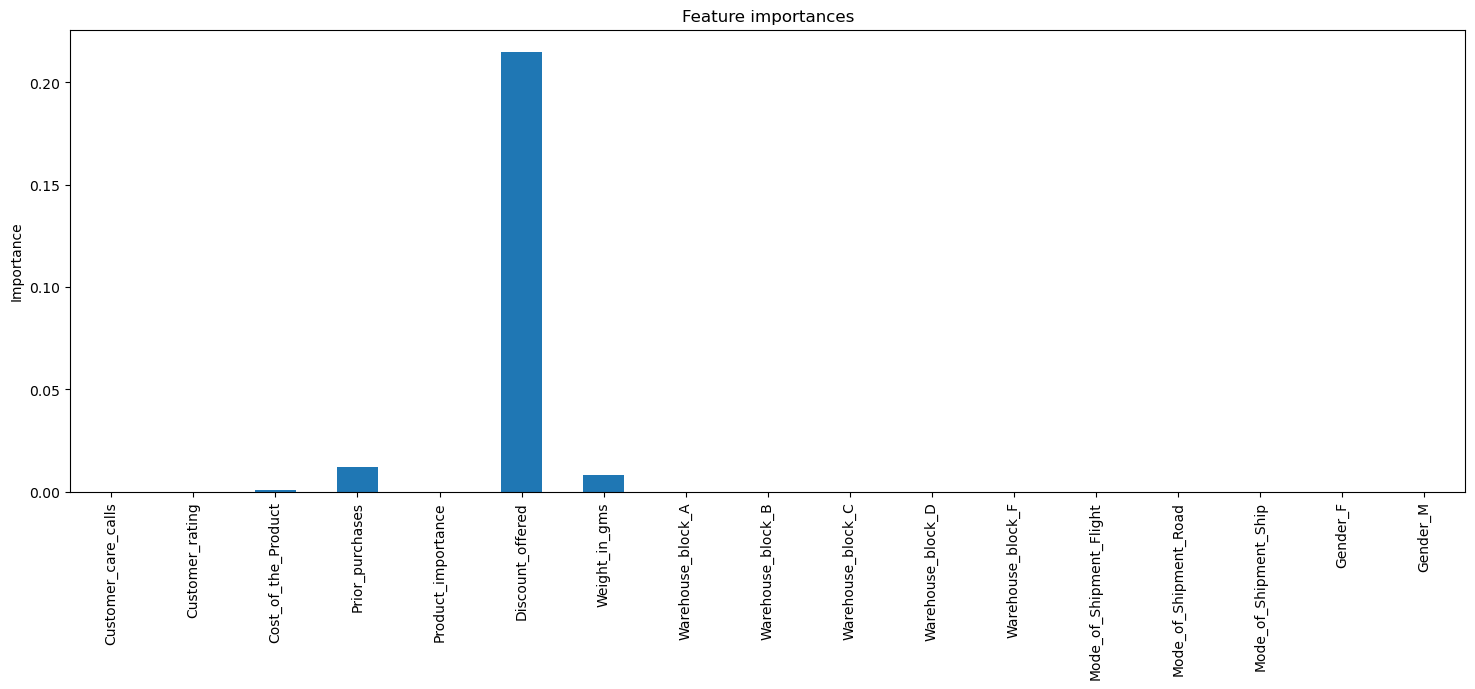

In [675]:
# plot feature importances 
plot_feature_importance(dt_model, X_train.columns)

### Model 1: Hyperparameter Tuning

Perform random search to optimize hyperparameters

In [676]:
# initialize new model
dt_model_tune= DecisionTreeClassifier(random_state=42)

In [677]:
# setup search grid
param_grid = { 
    'max_depth': [3, 5, 7, 9],
    'min_samples_leaf': [2, 3, 4, 5, 7],
    'criterion' :['gini', 'entropy', 'log_loss']
}

In [678]:
# run search
CV_dtc = GridSearchCV(estimator=dt_model_tune, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
CV_dtc.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 5, 7, 9],
                         'min_samples_leaf': [2, 3, 4, 5, 7]},
             verbose=1)

In [679]:
# display best found hyperparamater combination
CV_dtc.best_params_

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2}

In [680]:
# get best model
dt_model_best = CV_dtc.best_estimator_

In [681]:
# predict y values based on the validation set using best model
y_pred1_tuned = dt_model_best.predict(X_val)

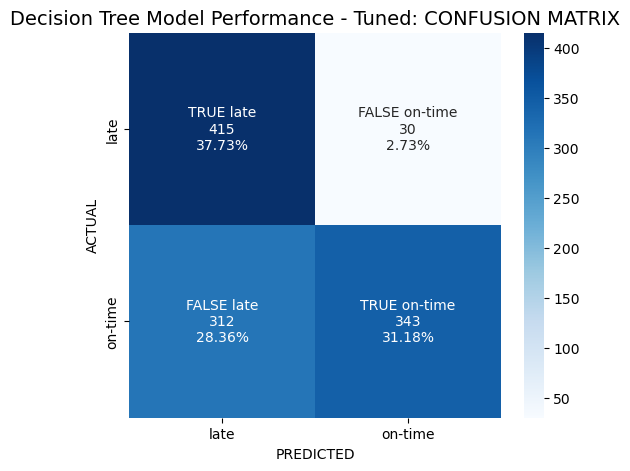

In [682]:
# generate confusion matrix for model1
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred1_tuned, title = 'Decision Tree Model Performance - Tuned')

In [683]:
# Generate Classification Report for model 1 Tuned
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred1_tuned, title = 'Decision Tree - Tuned Hyperparameters')

Decision Tree - Tuned Hyperparameters: CLASSIFICATION REPORT

              precision    recall  f1-score   support

        late       0.57      0.93      0.71       445
     on-time       0.92      0.52      0.67       655

    accuracy                           0.69      1100
   macro avg       0.75      0.73      0.69      1100
weighted avg       0.78      0.69      0.68      1100



In [684]:
# save model for comparison
tuned_models[5] = dt_model_best

# save predicted values
pred_values[5] = y_pred1_tuned

## Model 2: XGBoost

....

### Model 2: Create, train, evaluate

In [685]:
# fit the baseline model
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

xgb1.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None, nthread=4,
              num_parallel_tree=None, ...)

### Model 2: Performance on Validation Set

In [686]:
# predict y values based on the validation set
y_pred2 = xgb1.predict(X_val)

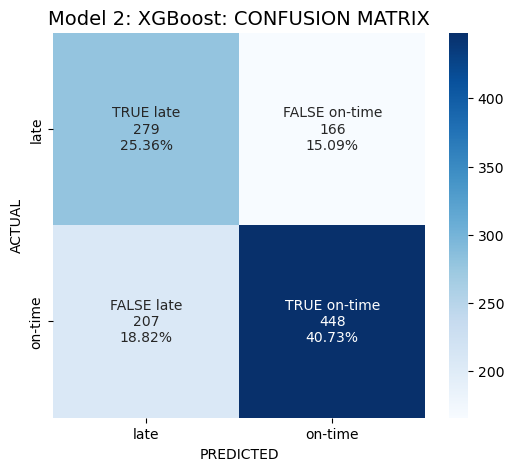

In [687]:
# generate confusion matrix for model2
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred2, title = 'Model 2: XGBoost')

In [688]:
# Generate Classification Report for model 2
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred2, title = 'Model 2: XGBoost Classifier')

Model 2: XGBoost Classifier: CLASSIFICATION REPORT

              precision    recall  f1-score   support

        late       0.57      0.63      0.60       445
     on-time       0.73      0.68      0.71       655

    accuracy                           0.66      1100
   macro avg       0.65      0.66      0.65      1100
weighted avg       0.67      0.66      0.66      1100



### Hyperparameter Tuning XGBoost

In [689]:
# fit the baseline model
xgb1_tuned = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [690]:
# setup search grid
param_grid_xg = { 
    'max_depth':[4,5,6],
    'min_child_weight':[4,5,6,8,10,12],
    'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}

In [691]:
# run search
CV_xgc = GridSearchCV(estimator=xgb1_tuned, param_grid=param_grid_xg, cv=5, verbose=1, n_jobs=-1)
CV_xgc.fit(X_train, y_train)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_b...
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=1000,
                                     n_jobs=None, nthread=4,
                                     num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                         'max_depth': [4, 5, 6],
                         'min_child_weight': [4, 5, 6, 8, 10, 12],
                         'subsample': [0.6, 0.7, 0.8, 0.9]},
             verbose=1)

In [692]:
# display best found hyperparamater combination
CV_xgc.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0.3,
 'max_depth': 4,
 'min_child_weight': 12,
 'subsample': 0.8}

In [693]:
# get best model
xgc_model_best = CV_xgc.best_estimator_

In [694]:
# predict y values based on the validation set using best model
y_pred2_tuned = xgc_model_best.predict(X_val)

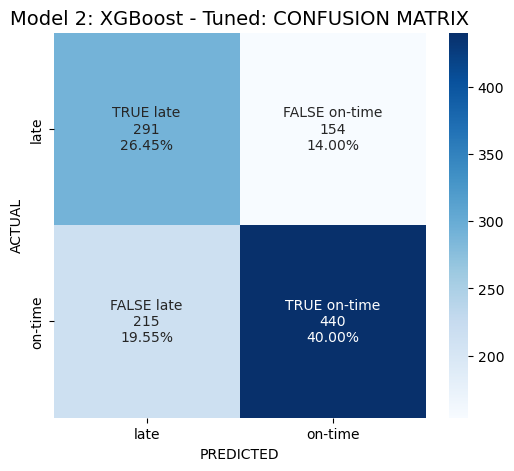

In [695]:
# generate confusion matrix for model2
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred2_tuned, title = 'Model 2: XGBoost - Tuned')

In [696]:
# Generate Classification Report for Tuned XGBoost
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred2_tuned, title = 'Model 2: XGBoost Classifier - Tuned')

Model 2: XGBoost Classifier - Tuned: CLASSIFICATION REPORT

              precision    recall  f1-score   support

        late       0.58      0.65      0.61       445
     on-time       0.74      0.67      0.70       655

    accuracy                           0.66      1100
   macro avg       0.66      0.66      0.66      1100
weighted avg       0.67      0.66      0.67      1100



### Second Round of Hyperparameter Tuning

In [697]:
# fit the partially tuned model
xgb2_tuned = XGBClassifier(
 learning_rate=0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=12,
 gamma=0.3,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [698]:
# setup search grid
param_grid_xg_2 = { 
    'n_estimators':[100, 200, 1000],
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],
    'reg_lambda':[0, 0.001, 0.005, 0.01, 0.05]
}

In [699]:
# run search
CV_xgc_2 = GridSearchCV(estimator=xgb2_tuned, param_grid=param_grid_xg_2, cv=5, verbose=1, n_jobs=-1)
CV_xgc_2.fit(X_train, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.3,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=12,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=1000,
                                     n_jobs=None, nthread=4,
                                     num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'n_estimators': [100, 200, 1000],
                         'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05],
                         'reg_lambda': [0, 0.001, 0.005, 0.01, 0.05]},
             verbose=1)

In [700]:
# display best found hyperparamater combination
CV_xgc_2.best_params_

{'n_estimators': 100, 'reg_alpha': 0.05, 'reg_lambda': 0.05}

In [701]:
# get best model
xgc_model_best_2 = CV_xgc_2.best_estimator_

In [702]:
# predict y values based on the validation set using best model
y_pred3_tuned = xgc_model_best_2.predict(X_val)

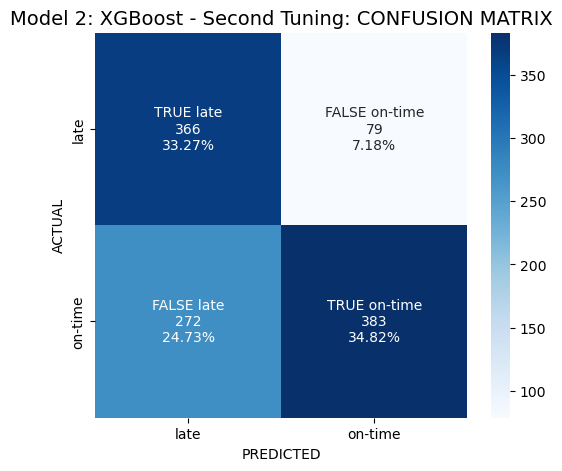

In [703]:
# generate confusion matrix for model2
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred3_tuned, title = 'Model 2: XGBoost - Second Tuning')

In [704]:
# Generate Classification Report for Tuned XGBoost
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred3_tuned, title = 'Model 2: XGBoost Classifier - Second Tuning')

Model 2: XGBoost Classifier - Second Tuning: CLASSIFICATION REPORT

              precision    recall  f1-score   support

        late       0.57      0.82      0.68       445
     on-time       0.83      0.58      0.69       655

    accuracy                           0.68      1100
   macro avg       0.70      0.70      0.68      1100
weighted avg       0.73      0.68      0.68      1100



In [705]:
# save model for comparison
tuned_models[6] = xgc_model_best_2

# save predicted values
pred_values[6] = y_pred3_tuned

# Part IV: Final Model Selection and Analysis (Decision Tree)

## Model Comparison 1: FALSE On-Time & FALSE Late  Rates

The Confusion Matrix gives FALSE On-Time and FALSE Late rates based on the entire validation population. This could be misleading when there's a huge class imbalance (not the case for this dataset). In this section, we calculate these rates as percentages of the actual class they are describing. 

By considering the "Late" class as the Positive class, the FALSE On-Time and FALSE Late rates can be calculated as functions of True Positive Rate (TPR) and False Positive Rate (FPR). 

* Positive Class : Late

    * **TRUE Late = TPR ***(Recall)***** 
        * out of the actual number of Late cases, how many were predicted as Late
    * **FALSE On-Time = 1 - TPR**
        * out of the actual number of Late cases, how many were predicted as On-Time
    * **FALSE Late = FPR ***(False Alarms)*****
        * out of the actual number of On-Time cases, how many were predicted as Late
     

,1-TPR (FALSE On-Time),FPR (FALSE Late)
Naive Bayes,0.013483,0.569466
Random Forest,0.062921,0.471756
Decision Tree,0.067416,0.476336
XGBoost,0.177528,0.415267
SVC,0.251685,0.375573
KNN,0.337079,0.378626
Logistic Regression,0.469663,0.287023


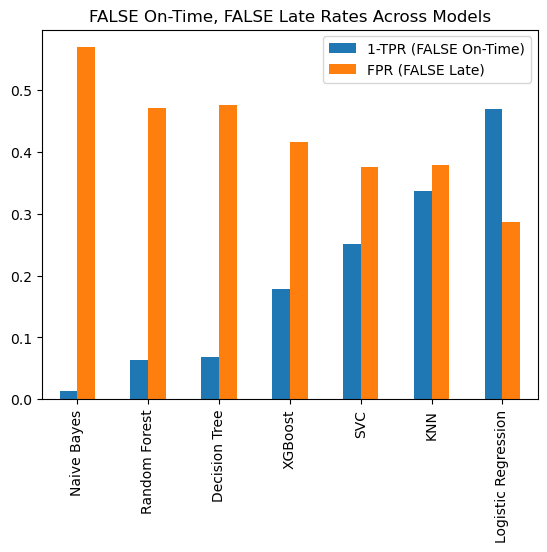

In [758]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# insert bar graph highlighting 'False On-Time Rate' and 'False Alarm Rate' 
models = ['Logistic Regression',
         'KNN',
         'Random Forest',
         'Naive Bayes',
          'SVC',
          'Decision Tree',
          'XGBoost']

recall_late = []
false_alarm = []
false_ontime = []

for i in range(0, len(tuned_models)):

    # True Positive Rate (with positive class = 0)
    tp = np.sum((pred_values[i] == 0) & (y_val == 0))
    fn = np.sum((pred_values[i] == 1) & (y_val == 0))
    tpr = tp / (tp + fn)
    recall_late.append(tpr)
    
    # False OnTime Rate = (1 - TPR)
    false_ontime.append(1-tpr)

    # False Positive Rate (false alarms) (with positive class = 0)
    fp = np.sum((pred_values[i] == 0) & (y_val == 1))
    tn = np.sum((pred_values[i]== 1) & (y_val == 1))
    fpr = fp / (fp + tn)
    false_alarm.append(fpr)
        
# sort models based on increasing False On-Time rates
metrics = pd.DataFrame({'1-TPR (FALSE On-Time)': false_ontime,
                        'FPR (FALSE Late)': false_alarm}, index=models)
metrics = metrics.sort_values(by=['1-TPR (FALSE On-Time)'])


fig_tmp = metrics.plot.bar(rot=90)
plt.title("FALSE On-Time, FALSE Late Rates Across Models")
metrics

    

* Naive Bayes has the lowest False On-Time rate but it also has the highest False Alarm rate at more than 50% of actual On-Time shipments.
* Random Forest and Decisions Tree show similar performance on both metrics. While their False On-Time rates are higher by 5% over Naive Bayes, their False Late rates are lower by 10%.

## Model Comparison 2: ROC Curves + AUC Score

The FPR/TPR values above were derived using the default probability threshold of 0.5.
By varying this threshold, the FPR/TPR values could change thus affecting model performance.
To compare the models across different thresholds, we use ROC and AUC Score.

**Note:** In this section, TPR is used (instead of 1-TPR) to be compatible with the sklearn roc and auc functions.
Minimizing (1 - TPR) is the same as maximizing (TPR).

In [759]:
# ROC curves of all models above

# fit SVC model again using "probability=True" parameter
i=4 #SVC model
svc_model = tuned_models[4]
svc_model.set_params(probability=True)
svc_model.fit(X_train,y_train)

tuned_models[4]=svc_model
pred_values[4]=svc_model.predict(X_val)

# roc curve for tpr = fpr (reference line)
random_probs = [0 for i in range(len(y_val))]
p_fpr, p_tpr, _ = roc_curve(y_val, random_probs)


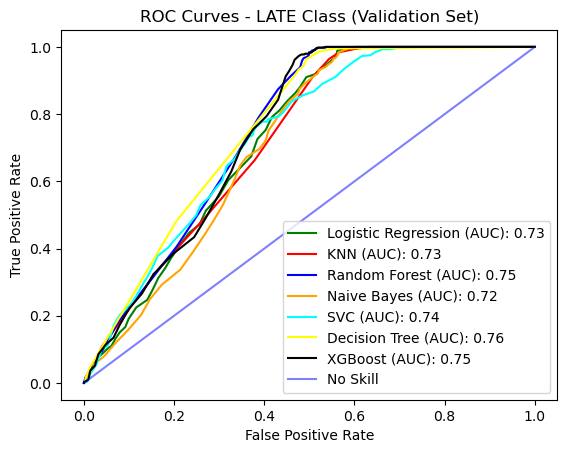

In [760]:
# initialize variables
fprVAL=[]
tprVAL=[]
threshVAL=[]
aucVAL=[]
color = ['green','red', 'blue', 'orange', 'cyan', 'yellow', 'black']

# calculate ROC Curve and AUC Score on Validation Data
for i in range(0, len(tuned_models)):

    # predict probability values for each validation sample
    val_prob = []
    val_prob = tuned_models[i].predict_proba(X_val)
    val_prob_0 = np.round(val_prob[:,0],2)
    
    # generate ROC Curve plot points
    fpr_tmp, tpr_tmp, thresh_tmp = roc_curve(y_val, val_prob_0, pos_label = 0, drop_intermediate=True)
    
    # calculate AUC Score
    auc_tmp = roc_auc_score(np.array(y_val), val_prob[:,1])
    #auc_tmp
    
    # append values
    fprVAL.append(fpr_tmp)
    tprVAL.append(tpr_tmp)
    threshVAL.append(thresh_tmp)
    aucVAL.append(auc_tmp)
    
    # generate labels
    label = models[i] + " (AUC): " + str(round(auc_tmp,2))
    
    plt.plot(fpr_tmp, tpr_tmp, color=color[i], label=label)

plt.plot(p_fpr, p_tpr, color='blue', alpha=0.5, label = 'No Skill')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curves - LATE Class (Validation Set)")
plt.show()

* The models have similar ROC plots.
* By adjusting the decision threshold, {Decision Tree, XGBoost, and Random Forest} can achieve very close to 100% TPR with the least False alarm rate compared to other models.
* Meanwhile, SVC has to sacrifice the most false alarms in order to get to 100% TPR.
 
* Finally, Decision Tree is chosen as it has the highest AUC score.

## FINAL MODEL Decision Tree: Test Performance

In [761]:
# Load test data
X_test = pd.read_csv('./data/x_test.csv')
y_test = np.ravel(pd.read_csv('./data/y_test.csv'))

In [762]:
X_test.shape

(1100, 17)

In [763]:
selected_model = 'Decision Tree'
final_model = tuned_models[models.index(selected_model)]
final_model

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=2,
                       random_state=42)

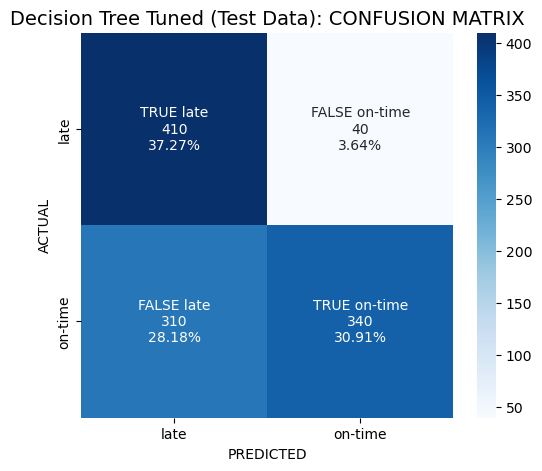

In [764]:
# predict y values based on the test set using best model
y_final_pred = final_model.predict(X_test)
# generate confusion matrix 
aai510_grp7_confusion_matrix(y_true = y_test, y_pred = y_final_pred, title = 'Decision Tree Tuned (Test Data)')

In [765]:
# Generate Classification Report
aai510_grp7_class_report(y_true = y_test, y_pred = y_final_pred, title = 'Decison Tree Tuned (Test Data)')

Decison Tree Tuned (Test Data): CLASSIFICATION REPORT

              precision    recall  f1-score   support

        late       0.57      0.91      0.70       450
     on-time       0.89      0.52      0.66       650

    accuracy                           0.68      1100
   macro avg       0.73      0.72      0.68      1100
weighted avg       0.76      0.68      0.68      1100



## Compare Probability Distributions of Predicted Values Between Validation and Test Set

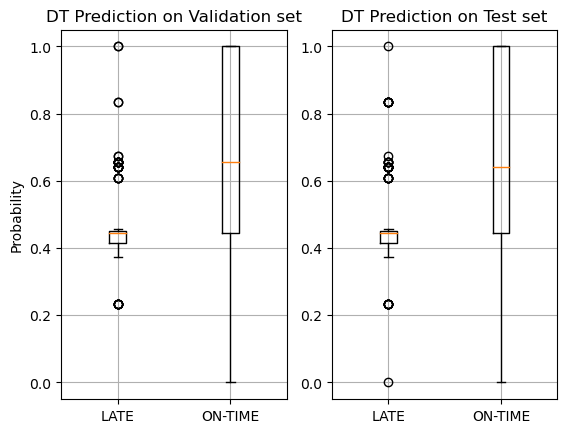

In [766]:
# Probability Distribution of Predicted Samples (Test vs Validation)

labels = ['LATE', 'ON-TIME']

val_pred = final_model.predict_proba(X_val)
test_pred = final_model.predict_proba(X_test)

val_dist_ax = plt.subplot(1, 2, 1)
test_dist_ax = plt.subplot(1, 2, 2)

val_dist_ax.boxplot([val_pred[y_val==0][:,1], val_pred[y_val==1][:,1]], labels=labels, showfliers=True)
test_dist_ax.boxplot([test_pred[y_test==0][:,1],test_pred[y_test==1][:,1]], labels=labels, showfliers=True)

val_dist_ax.set_title('DT Prediction on Validation set')
test_dist_ax.set_title('DT Prediction on Test set')
val_dist_ax.set_ylabel('Probability')
val_dist_ax.grid('on')
test_dist_ax.grid('on')


Visually, there is no significant difference in the predicted probability distributions when the model is applied to both the validation set and test set. 

## Evaluate Overfitting by Comparing ROC Curves of Training, Validation, and Test Sets

In [767]:
# ROC Curve
# Since the focus is on detection of LATE arrivals, the LATE class is considered the POSITIVE class

# predict probabilities
train_prob = final_model.predict_proba(X_train)
val_prob = final_model.predict_proba(X_val)
test_prob = final_model.predict_proba(X_test)

# roc curve for DT
# use probabilty first column - i.e. probability that this shipment will be LATE
# positive label set to 0
fprTR, tprTR, threshTR = roc_curve(y_train, train_prob[:,0], pos_label = 0)
fprVAL, tprVAL, threshVAL = roc_curve(y_val, val_prob[:,0], pos_label = 0)
fprTEST, tprTEST, threshTEST = roc_curve(y_test, test_prob[:,0], pos_label = 0)

# roc curve for tpr = fpr (reference line)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)


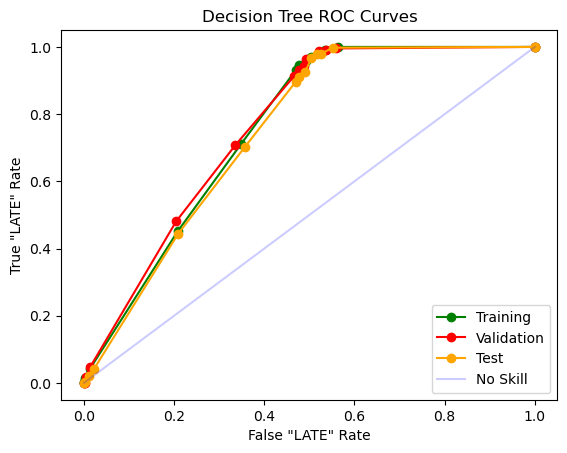

In [768]:
#plot roc curves
plt.clf()
plt.plot(fprTR, tprTR, marker = 'o', color='green', label='Training')
plt.plot(fprVAL, tprVAL, marker = 'o', color='red', label='Validation')
plt.plot(fprTEST, tprTEST, marker = 'o', color='orange', label='Test')
plt.plot(p_fpr, p_tpr, color='blue', alpha=0.2, label = 'No Skill')

# title
plt.title('Decision Tree ROC Curves')

#legend
plt.legend(loc='lower right')

# x label
plt.xlabel('False "LATE" Rate')
# y label
plt.ylabel('True "LATE" Rate')

plt.show()


The ROC curves on the training, validation, and test sets are almost aligned with each other. This suggests the the model does not overfit the training data. It also suggests that the model could not learn anymore from the available data.

## Threshold Value Evaluation

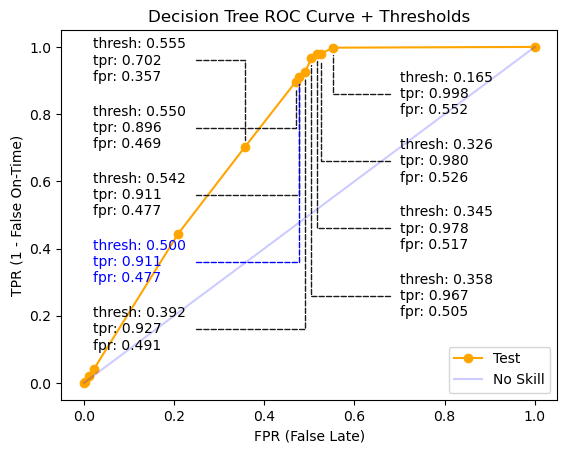

In [772]:
#plot roc curve of Test Data: Threshold, TPR, FPR
plt.clf()
plt.plot(fprTEST, tprTEST, marker = 'o', color='orange', label='Test')
plt.plot(p_fpr, p_tpr, color='blue', alpha=0.2, label = 'No Skill')

# title
plt.title('Decision Tree ROC Curve + Thresholds')

#legend
plt.legend(loc='lower right')

# x label
plt.xlabel('FPR (False Late)')
# y label
plt.ylabel('TPR (1 - False On-Time)')

# add threshold labels for select ROC Curve points
select_thresh_idx = [5, 6, 7, 8, 9, 10, 11, 12]

# x-axis and y-axis positions of labels
xpos = np.array([0.02, 0.02, 0.02, 0.02, 0.7, 0.7, 0.7, 0.7])
ypos = np.array([0.9, 0.7, 0.5, 0.1, 0.2, 0.4, 0.6, 0.8])

# annotate figure
for idx in select_thresh_idx:
    i = select_thresh_idx.index(idx),
    plt.annotate('thresh: %0.3f\ntpr: %0.3f\nfpr: %0.3f' % (threshTEST[idx],tprTEST[idx],fprTEST[idx]), 
            xy=(fprTEST[idx], tprTEST[idx]), 
            xytext =(xpos[i], ypos[i]),
            textcoords = 'data',
            arrowprops=dict(color='0.1',
                            arrowstyle='-',
                            shrinkA = 5, shrinkB = 5,
                            linestyle = '--',
                            connectionstyle="angle,angleA=180,angleB=-90,rad=0"))
    
# add ROC curve of selected Decision Tree Model (threshold = 0.5)
# class '0' is the target class

fp = np.sum((y_final_pred == 0) & (y_test == 1))
tp = np.sum((y_final_pred == 0) & (y_test == 0))

fn = np.sum((y_final_pred == 1) & (y_test == 0))
tn = np.sum((y_final_pred == 1) & (y_test == 1))

fpr = fp / (fp + tn)
tpr = tp / (tp + fn)

plt.annotate('thresh: %0.3f\ntpr: %0.3f\nfpr: %0.3f' % (0.5,tpr,fpr), 
            xy=(fpr, tpr), 
            xytext =(0.02, 0.3),
            textcoords = 'data',
            color = 'blue',
            arrowprops=dict(color='blue',
                            arrowstyle='-',
                            shrinkA = 5, shrinkB = 5,
                            linestyle = '--',
                            connectionstyle="angle,angleA=180,angleB=-90,rad=0"))

plt.show()
    

Depending on the business application, the classifier's decision threshold could be adjusted to achieve the desired TPR/FPR values. For example, by setting the threshold at 0.165, 99.8% of shipments that most likely will arrive late is correctly identified. However, this comes with a trade-off where 55.2% of shipments that most likely will arrive on-time is incorrectly labeled as late.

# Part V: Conclusion

Comparing all 7 models against each other it was clear that while overall accuracy performance was the same, the models varied widely in their false On-Time (missed late shipment) and false Late (false alarm) rates. Therefore these metrics were used to evaluate and downselect which model best fit our business needs.

### Business Impact

- False On-Time: When the model fails to identify a shipment that will be late. This has the highest potential impact to our business, as late shipments create a negative customer experience. This in turn reduces future revenue as customers choose alternative options.

- False Late: When the models identifies a shipment as being late, however it will actually be on-time (false alarm). While not as impactful as the poor customer experience of missing a late shipment, a false alarm wastes company time and resources.

### Model Selection

Based on the validation set we attempted to find a balance of minimizing False On-Time as much as possible while maintaining a reasonable False Late rate. Naive Bayes gave the extreme case of very low False On-Time at 0.6% but the highest false alarm rate of 33.9% . While this would have given a great customer experience, as a company we felt the cost of the false alarm rate would be too high. Instead we chose the next model with a slightly higher False On-Time rate, Decision Tree at 2.7% False On-Time and 28.4% false alarm rate. One additional advantage to decision tree is that it is a simple, fast model that is very explainable. This is important to understand how the model is making decisions and how changes in the business environment may impact the model.

Finally we tested the Decision Tree model on a holdout test set to understand how well it generalizes to unseen data. As shown by the ROC curves the performance of the model is very similar across the training, validation and test datasets. This indicates the model is not overfitted and can generalize well to unseen data.

Going forward the Decision Tree model will be deployed for business use, with potential future project focusing on reducing the high false alarm rate.